In [171]:
!pip install nba_api==1.1.14

  Using cached numpy-1.26.4-cp39-cp39-macosx_10_9_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp39-cp39-macosx_10_9_x86_64.whl (20.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: nba_api
    Found existing installation: nba_api 1.5.0
    Uninstalling nba_api-1.5.0:
      Successfully uninstalled nba_api-1.5.0

[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [100]:
from nba_api.stats.endpoints import leaguegamelog
import pandas as pd
from tqdm import tqdm
import time

def get_season_data(season):
  gamefinder = leaguegamelog.LeagueGameLog(league_id='00', season=season)
  games = gamefinder.get_data_frames()[0]
  games['IS_HOME'] = games['MATCHUP'].apply(lambda x: 0 if '@' in x else 1)
  winning_teams = games[games['WL'] == "W"][['SEASON_ID', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'PTS', 'IS_HOME']]
  losing_teams = games[games['WL'] == "L"][['GAME_ID', 'TEAM_ABBREVIATION', 'TEAM_NAME', 'PTS', 'IS_HOME']]
  merged = pd.merge(winning_teams, losing_teams, on='GAME_ID', suffixes=('_W', '_L'))
  merged['MARGIN'] = merged['IS_HOME_W'].apply(lambda x: 1 if x == 1 else -1) * (merged['PTS_W'] - merged['PTS_L'])
  return merged

final_df = pd.DataFrame()
for season in tqdm(range(1946, 2025)):
  df = get_season_data(season)
  final_df = pd.concat([final_df, df])
  time.sleep(1)

final_df.to_csv('nba_data.csv')




100%|██████████| 79/79 [03:18<00:00,  2.52s/it]


In [142]:
final_df

,SEASON_ID,GAME_ID,GAME_DATE,MATCHUP,TEAM_ABBREVIATION_W,TEAM_NAME_W,PTS_W,IS_HOME_W,TEAM_ABBREVIATION_L,TEAM_NAME_L,PTS_L,IS_HOME_L,MARGIN
0,21996,0029600002,1996-11-01,CLE @ NJN,CLE,Cleveland Cavaliers,90,0,NJN,New Jersey Nets,77,1,-13
1,21996,0029600001,1996-11-01,CHI @ BOS,CHI,Chicago Bulls,107,0,BOS,Boston Celtics,98,1,-9
2,21996,0029600010,1996-11-01,DAL @ DEN,DAL,Dallas Mavericks,92,0,DEN,Denver Nuggets,91,1,-1
3,21996,0029600009,1996-11-01,HOU vs. SAC,HOU,Houston Rockets,96,1,SAC,Sacramento Kings,85,0,11
4,21996,0029600013,1996-11-01,LAC @ GSW,LAC,Los Angeles Clippers,97,0,GSW,Golden State Warriors,85,1,-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,22024,0022401200,2025-04-13,SAC vs. PHX,SAC,Sacramento Kings,109,1,PHX,Phoenix Suns,98,0,11
1226,22024,0022401197,2025-04-13,SAS vs. TOR,SAS,San Antonio Spurs,125,1,TOR,Toronto Raptors,118,0,7
1227,22024,0022401196,2025-04-13,OKC @ NOP,OKC,Oklahoma City Thunder,115,0,NOP,New Orleans Pelicans,100,1,-15
1228,22024,0022401194,2025-04-13,MEM vs. DAL,MEM,Memphis Grizzlies,132,1,DAL,Dallas Mavericks,97,0,35


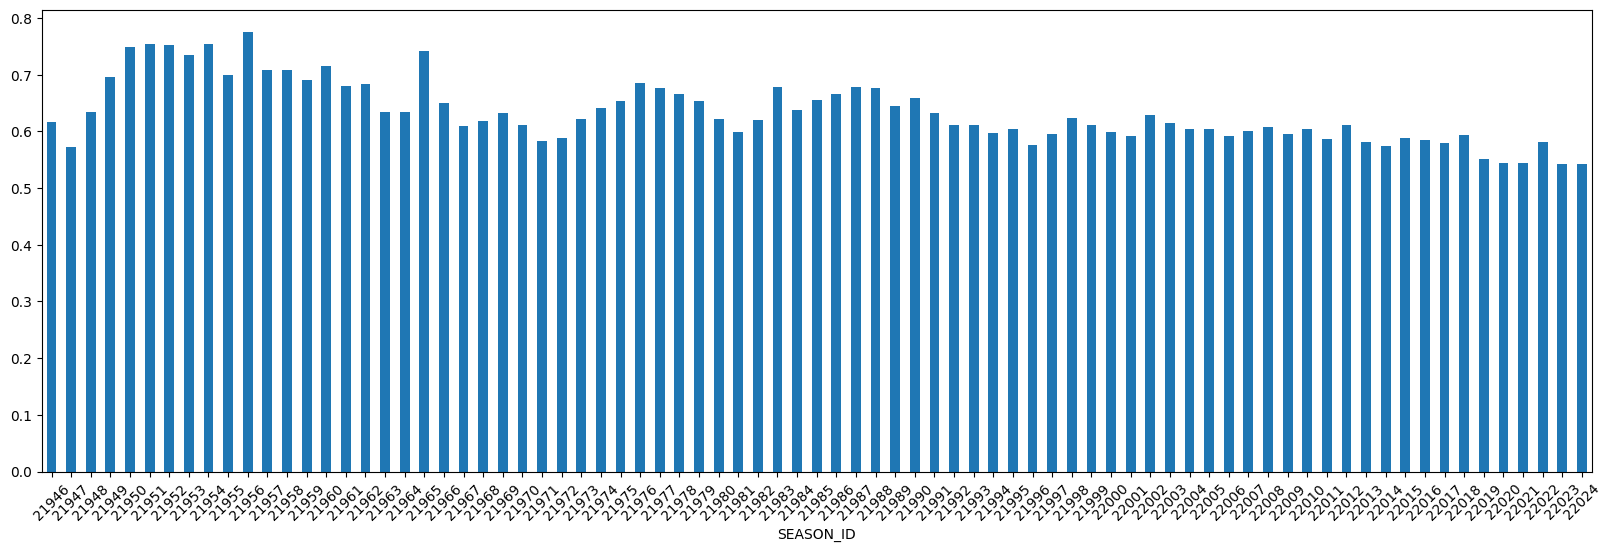

In [116]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,6))
final_df.groupby(['SEASON_ID'])['IS_HOME_W'].mean().plot(kind='bar')
plt.xticks(rotation=45);

In [125]:
final_df = final_df[final_df['SEASON_ID'].astype(int) >= 21996]

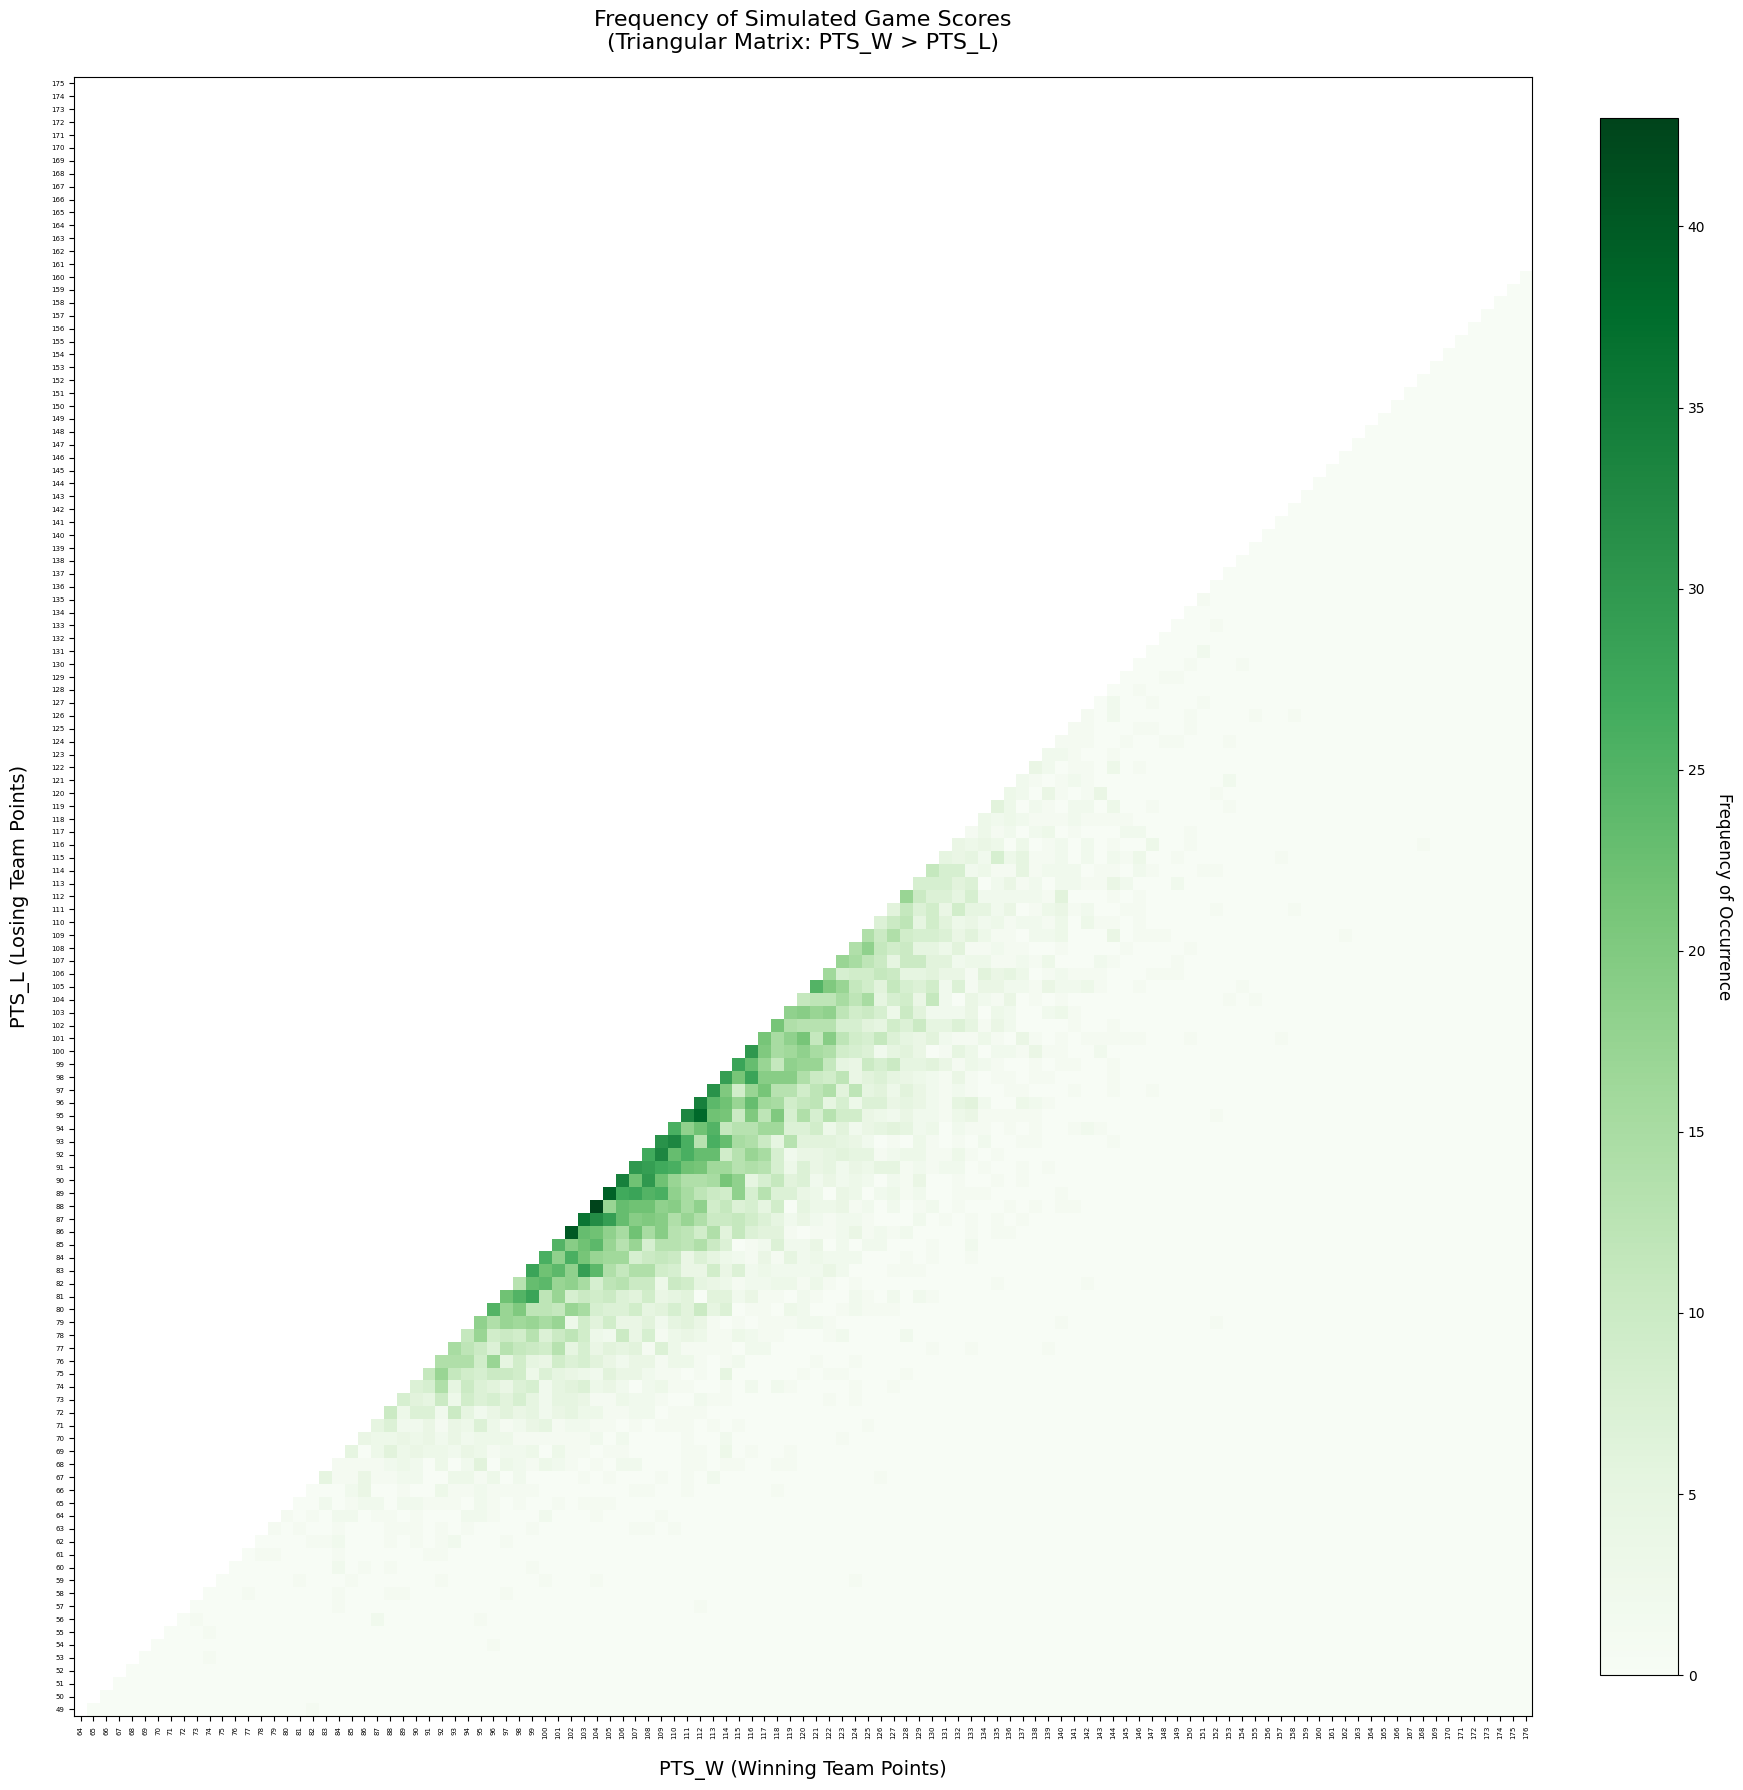

In [153]:
from matplotlib import colors as mcolors
# Create pivot of frequencies
score_freq = final_df.pivot_table(
    index='PTS_L', 
    columns='PTS_W', 
    aggfunc='size', 
    fill_value=0
)

# Determine full score range for both axes
min_score_l = score_freq.index.min()
min_score_w = score_freq.columns.min()
max_score_l = score_freq.index.max()
max_score_w = score_freq.columns.max()

# Fill full score range for both dimensions (Mandatory for correct tick placement)
score_freq = score_freq.reindex(
    index=range(min_score_l, max_score_l + 1),
    columns=range(min_score_w, max_score_w + 1),
    fill_value=0
)

# Mask out invalid (PTS_W <= PTS_L) combinations
# k=0 ensures the diagonal (PTS_W == PTS_L) is also masked out, 
# as games cannot end in a tie (unless the user wants to include 
# the hypothetical tie row/column, k=1 would include the diagonal).
mask = np.tri(*score_freq.shape, k=0, dtype=bool)
# We apply the mask *before* plotting
masked_data = np.ma.masked_where(mask, score_freq)


# =============================================================
# 3. Create Figure and Set Axes (BEFORE imshow)
# =============================================================
fig, ax = plt.subplots(figsize=(18, 18))

# Define the full range of ticks
tick_range_l = np.arange(min_score_l, max_score_l + 1)
tick_range_w = np.arange(min_score_w, max_score_w + 1)

# Set labels and rotation for better visibility
font_size = max(5, 400 / len(tick_range_l)) # Dynamically adjust font size

# Set ticks for X and Y axes
ax.set_xticks(tick_range_w - min_score_w) # Adjusting for 0-based array index
ax.set_yticks(tick_range_l - min_score_l) # Adjusting for 0-based array index

# Force all tick marks and labels to render using FixedLocator
ax.xaxis.set_major_locator(FixedLocator(tick_range_w - min_score_w))
ax.yaxis.set_major_locator(FixedLocator(tick_range_l - min_score_l))

# Set labels for each tick to display the actual score value
ax.set_xticklabels(tick_range_w, fontsize=font_size, rotation=90)
ax.set_yticklabels(tick_range_l, fontsize=font_size)

# Set limits to perfectly frame the data without extra padding
ax.set_xlim(-0.5, len(tick_range_w) - 0.5)
ax.set_ylim(-0.5, len(tick_range_l) - 0.5)

# =============================================================
# 4. Create the Heatmap (Plotting)
# =============================================================
# The data is plotted after all axes and ticks are configured.
im = ax.imshow(
    masked_data, 
    cmap='Greens', # Using 'viridis' for better color perception
    aspect='equal', 
    origin='lower',
    interpolation='nearest'
)

# =============================================================
# 5. Labels and Colorbar
# =============================================================
ax.set_xlabel('PTS_W (Winning Team Points)', fontsize=14, labelpad=15)
ax.set_ylabel('PTS_L (Losing Team Points)', fontsize=14, labelpad=15)
ax.set_title(
    'Frequency of Simulated Game Scores\n(Triangular Matrix: PTS_W > PTS_L)', 
    fontsize=16, 
    pad=20
)

# Add a colorbar
cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label('Frequency of Occurrence', rotation=270, labelpad=20, fontsize=12)

plt.tight_layout()
plt.show()

In [161]:
def check_scorigami(pts_w, pts_l):
    if pts_w <= pts_l:
        return "Invalid score combination: Winning points must be greater than losing points."
    freq = score_freq.at[pts_l, pts_w]
    if freq == 0:
        return f"Scorigami! The score combination {pts_w}-{pts_l} has never occurred."
    else:
        return f"The score combination {pts_w}-{pts_l} has occurred {freq} times. The last time it occurred was on {final_df[(final_df['PTS_W'] == pts_w) & (final_df['PTS_L'] == pts_l)]['GAME_DATE'].max()} when the {final_df[(final_df['PTS_W'] == pts_w) & (final_df['PTS_L'] == pts_l)]['TEAM_NAME_W'].values[0]} defeated the {final_df[(final_df['PTS_W'] == pts_w) & (final_df['PTS_L'] == pts_l)]['TEAM_NAME_L'].values[0]}."
    
check_scorigami(88, 70)

'The score combination 88-70 has occurred 3 times. The last time it occurred was on 2014-12-12 when the New Jersey Nets defeated the Golden State Warriors.'

In [176]:
from nba_api.stats.endpoints import leaguegamefinder
import pandas as pd

# Get games from a specific date
gamefinder = leaguegamefinder.LeagueGameFinder(
    date_from_nullable='10/17/2025',
    date_to_nullable='10/17/2025',
    league_id_nullable='00'
)

games = gamefinder.get_data_frames()[0]

# Each game appears twice (once per team), so filter
games_unique = games.drop_duplicates(subset=['GAME_ID'])

print(games_unique[['GAME_DATE', 'MATCHUP', 'TEAM_NAME', 'PTS', 'WL']])

     GAME_DATE      MATCHUP               TEAM_NAME  PTS WL
0   2025-10-17  LAL vs. SAC      Los Angeles Lakers  116  L
2   2025-10-17    MIN @ PHI  Minnesota Timberwolves  110  L
4   2025-10-17    DEN @ OKC          Denver Nuggets   91  L
6   2025-10-17    BKN @ TOR           Brooklyn Nets  114  L
8   2025-10-17    MEM @ MIA       Memphis Grizzlies  141  W
10  2025-10-17    CHA @ NYK       Charlotte Hornets  108  L
11  2025-10-17  SAS vs. IND       San Antonio Spurs  133  W
14  2025-10-17    LAC @ GSW             LA Clippers  106  W


In [177]:
games_unique

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,12025,1610612747,LAL,Los Angeles Lakers,0012500007,2025-10-17,LAL vs. SAC,L,238,116,...,0.724,8,25,33,28,10,3,9,21,-1.0
2,12025,1610612750,MIN,Minnesota Timberwolves,0012500071,2025-10-17,MIN @ PHI,L,240,110,...,0.813,8,31,39,22,9,5,22,20,-16.0
4,12025,1610612743,DEN,Denver Nuggets,0012500067,2025-10-17,DEN @ OKC,L,239,91,...,0.588,11,34,45,23,13,5,13,19,-3.0
6,12025,1610612751,BKN,Brooklyn Nets,0012500065,2025-10-17,BKN @ TOR,L,239,114,...,0.793,14,32,46,28,5,3,23,28,-5.0
8,12025,1610612763,MEM,Memphis Grizzlies,0012500006,2025-10-17,MEM @ MIA,W,241,141,...,0.744,14,36,50,26,7,4,13,20,16.0
10,12025,1610612766,CHA,Charlotte Hornets,0012500066,2025-10-17,CHA @ NYK,L,240,108,...,0.727,10,31,41,30,9,3,21,20,-5.0
11,12025,1610612759,SAS,San Antonio Spurs,0012500068,2025-10-17,SAS vs. IND,W,241,133,...,0.833,12,30,42,31,9,10,15,19,29.0
14,12025,1610612746,LAC,LA Clippers,0012500069,2025-10-17,LAC @ GSW,W,241,106,...,0.667,15,35,50,30,11,4,21,15,3.0
